In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from transformers import AutoModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Load & Transform data

In [2]:
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

In [3]:
true_df["label"] = 1  # Real news
fake_df["label"] = 0  # Fake news

In [4]:
df = pd.concat([true_df, fake_df], ignore_index=True)

In [5]:
print(df["label"].value_counts())

0    23481
1    21417
Name: label, dtype: int64


In [6]:
df = df[["title", "text", "label"]]

In [7]:
df["content"] = df["title"] + " " + df["text"]

In [8]:
df.dropna(inplace=True)

Take the sample

In [13]:
# Shuffle the entire dataset by sampling 100% of rows (frac=1) with a fixed random seed for reproducibility
df = df.sample(frac=1000/44898, random_state=537).reset_index(drop=True)

In [14]:
df = df[["content", "label"]]

In [15]:
df.head()

,content,label
0,Figures show Trump spent $66 million of his ow...,1
1,Trump raises about $90 million in August WASH...,1
2,Iran's Soleimani arrives in Kurdish region for...,1
3,Putin Declares Syria A “No Fly Zone”…While Oba...,0
4,Remember Trump’s Biggest Campaign Promise? Ye...,0


Text tokonzing

In [18]:
df.shape

(1000, 2)

In [20]:
df['label'].value_counts()

0    521
1    479
Name: label, dtype: int64

In [21]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Set the maximum number of tokens is 512

In [22]:
# Convert all text in the dataframe to tokenized inputs
inputs = tokenizer(df['content'].tolist(), return_tensors="pt", truncation=True, padding=True,max_length=512)
model = AutoModel.from_pretrained("distilbert-base-uncased")

with torch.no_grad():  # Disable gradient computation (faster)
    outputs = model(**inputs)

In [23]:
outputs.last_hidden_state.shape

torch.Size([1000, 512, 768])

In [24]:
outputs.last_hidden_state[:,0,:].shape 

torch.Size([1000, 768])

# **Using all information of the token layer (By mean)**

In [25]:
embeddings_mean = outputs.last_hidden_state.mean(dim=1)
embeddings_mean.shape

torch.Size([1000, 768])

In [26]:
embeddings_mu_np = embeddings_mean.numpy()

Standardization

In [35]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(embeddings_mu_np)

Split the dataset into training and testing sets

In [37]:
Train=df_scaled[:800]
Train_labels=df['label'][:800]
Test=df_scaled[800:]
Test_labels=df['label'][800:]

# Select the baseline model

LogisticRegression

In [43]:
from sklearn.model_selection import cross_validate
logis_clf = LogisticRegression()

scores = cross_validate(logis_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.97625
[0.98  0.99  0.955 0.98 ]


Naive Bayes Model

In [42]:
NB_clf = GaussianNB()
scores = cross_validate(NB_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.92875
[0.94  0.885 0.935 0.955]


Decision Tree

In [45]:
DT_clf = tree.DecisionTreeClassifier()
scores = cross_validate(DT_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.8175
[0.795 0.81  0.855 0.81 ]


Ada boost

In [47]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
scores = cross_validate(ada_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

0.93625
[0.94  0.92  0.935 0.95 ]


Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier()
scores = cross_validate(RF_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.92875
[0.95  0.885 0.94  0.94 ]


Logistic Regression Best performance for token aggregation

In [51]:
logis_clf.fit(Train, Train_labels)
logis_clf.score(Test, Test_labels)

0.97

For unseen data, the logistic regression can provide 97% accuracy

# Using CLS token for classification

In [50]:
embeddings_np_NoAggreation=outputs.last_hidden_state[:,0,:].numpy()

In [52]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(embeddings_np_NoAggreation)

In [53]:
Train=df_scaled[:800]
Train_labels=df['label'][:800]
Test=df_scaled[800:]
Test_labels=df['label'][800:]

Logistic Regression

In [ ]:
logis_clf = LogisticRegression()

scores = cross_validate(logis_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.97375
[0.985 0.97  0.955 0.985]


Navie Bayes classifer

In [56]:
NB_clf = GaussianNB()
scores = cross_validate(NB_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.915
[0.915 0.89  0.915 0.94 ]


Decision Tree

In [57]:
DT_clf = tree.DecisionTreeClassifier()
scores = cross_validate(DT_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.8625
[0.85  0.905 0.89  0.805]


AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
scores = cross_validate(ada_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

0.9312499999999999
[0.965 0.94  0.92  0.9  ]


Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier()
scores = cross_validate(RF_clf, Train, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.93625
[0.935 0.955 0.935 0.92 ]


Logistic Regression also having the best performance

In [60]:
logis_clf.fit(Train, Train_labels)
logis_clf.score(Test, Test_labels)

0.975

The model performance is similar using cls token and aggreation token

PCA method

In [61]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(embeddings_mu_np)
explained_variance_ratio_ = []
pca = PCA(n_components=500)
X_pca=pca.fit(df_scaled)

Using 85% explained variance

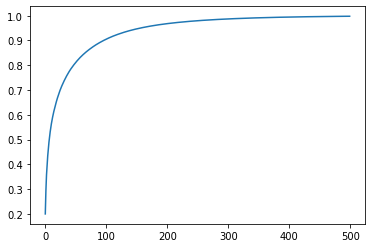

66

In [71]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.show()
temp=np.cumsum(X_pca.explained_variance_ratio_)
temp[temp <= 0.85].shape[0]

In [73]:
pca = PCA(n_components=temp[temp <= 0.85].shape[0]-1)
X_pca=pca.fit_transform(df_scaled)

In [74]:
X_pca.shape

(1000, 65)

In [75]:
Train_pca=X_pca[:800]
Train_labels=df['label'][:800]
Test_pca=X_pca[800:]
Test_labels=df['label'][800:]

Logistic Regression

In [76]:
logis_clf = LogisticRegression()
Train_labels
scores = cross_validate(logis_clf, Train_pca, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.94375
[0.95  0.94  0.95  0.935]


Navie Bayes classifer

In [77]:
NB_clf = GaussianNB()
scores = cross_validate(NB_clf, Train_pca, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.9187500000000001
[0.955 0.915 0.905 0.9  ]


Decision Tree

In [78]:
DT_clf = tree.DecisionTreeClassifier()
scores = cross_validate(DT_clf, Train_pca, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.875
[0.89  0.855 0.875 0.88 ]


AdaBoost

In [79]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
scores = cross_validate(ada_clf, Train_pca, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\va472\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

0.9325
[0.96  0.915 0.925 0.93 ]


Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier()
scores = cross_validate(RF_clf, Train_pca, Train_labels, cv=4,
                        scoring=('accuracy'),
                        return_train_score=True)
print(scores['test_score'].mean())
print(scores['test_score'])

0.9162500000000001
[0.92  0.89  0.925 0.93 ]


Logistic Regression also having the best performance but reduce 3% accuracy

In [82]:
logis_clf.fit(Train_pca, Train_labels)
logis_clf.score(Test_pca, Test_labels)

0.935

The final output provide same insight